In [1]:
import numpy as np
import lasagne
import theano
import theano.tensor as T 

import tiff_helpers
import os

%matplotlib inline 
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled)


In [2]:
# get image path
load_folder = '/media/arimorcos/SSD 1/AM144/141203'
test_tiff = 'AM144_001_001.tif'
load_tiff = os.path.join(load_folder, test_tiff)

# load in red image 
num_pages = tiff_helpers.get_num_tiff_pages(load_tiff)
red_test = tiff_helpers.read_tiff(load_tiff, range(1, num_pages, 2)).astype(theano.config.floatX)

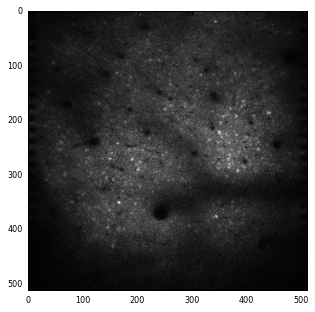

In [3]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.imshow(red_test[:, :, 100], cmap='gray');

In [4]:
batch_size = 32

In [5]:
# Construct spatial transformer network 

W_ini = lasagne.init.GlorotUniform()

# Input layer with size (batch_size, num_channels, height, width).
# In our case, each channel will represent the image to change and the reference image.
input_layer = lasagne.layers.InputLayer((batch_size, 2, 512, 512))

# convolutions 
conv_layer_1 = lasagne.layers.Conv2DLayer(input_layer, num_filters=64, filter_size=(3, 3),
                                  stride=1, pad='full', name='conv_1', W=W_ini)
conv_layer_2 = lasagne.layers.Conv2DLayer(conv_layer_1, num_filters=64, filter_size=(3, 3),
                                  stride=1, pad='full', name='conv_2', W=W_ini)

# pool
pool_layer_1 = lasagne.layers.MaxPool2DLayer(conv_layer_2, pool_size=(2, 2), name='pool_1')

# more convolutions 
conv_layer_3 = lasagne.layers.Conv2DLayer(pool_layer_1, num_filters=128, filter_size=(3, 3),
                                  stride=1, pad='full', name='conv_3', W=W_ini)
conv_layer_4 = lasagne.layers.Conv2DLayer(conv_layer_3, num_filters=128, filter_size=(3, 3),
                                  stride=1, pad='full', name='conv_4', W=W_ini)

# pool
pool_layer_2 = lasagne.layers.MaxPool2DLayer(conv_layer_4, pool_size=(2, 2), name='pool_2')

# more convolutions 
conv_layer_5 = lasagne.layers.Conv2DLayer(pool_layer_1, num_filters=256, filter_size=(3, 3),
                                  stride=1, pad='full', name='conv_5', W=W_ini)
conv_layer_6 = lasagne.layers.Conv2DLayer(conv_layer_3, num_filters=256, filter_size=(3, 3),
                                  stride=1, pad='full', name='conv_6', W=W_ini)

# pool
pool_layer_3 = lasagne.layers.MaxPool2DLayer(conv_layer_6, pool_size=(2, 2), name='pool_3')

# Dense layers 
dense_layer_1 = lasagne.layers.DenseLayer(pool_layer_3, num_units=128, W=W_ini,
                                         name='dense_1')

# Initialize affine transform to identity
b = np.zeros((2, 3), dtype=theano.config.floatX)
b[0, 0] = 1
b[1, 1] = 1

# Final affine layer 
affine_layer = lasagne.layers.DenseLayer(dense_layer_1, num_units=6, W=lasagne.init.Constant(0.0),
                                         b=b.flatten(), nonlinearity=lasagne.nonlinearities.identity,
                                         name='affine')

# Finally, create the transformer network 
transformer = lasagne.layers.TransformerLayer(incoming=input_layer, 
                                             localization_network=affine_layer,
                                             downsample_factor=1)

In [32]:
# Format a test image appropriately 
input_imgs = red_test[:, :, 0:2]
test_input = np.expand_dims(np.transpose(input_imgs, axes=(2, 0, 1)), 3)
test_input = np.tile(test_input, (1, 1, 1, 32))
test_input = np.transpose(test_input, axes=(3, 0, 1, 2))

# format test reference 
test_ref = np.expand_dims(red_test[:, :, 1], 2)
test_ref = np.tile(test_ref, (1, 1, 32))
test_ref = np.transpose(test_ref, axes=(2, 0, 1))
test_ref.shape

(32, 512, 512)

In [74]:
# Create input tensor
input_batch = T.tensor4('input_batch', dtype=theano.config.floatX)

# Create reference tensor (batch_size, 1, height, width)
ref_imgs = T.tensor3('ref_imgs', dtype=theano.config.floatX)

# Create symbolic output 
output = lasagne.layers.get_output(transformer, input_batch, deterministic=True)

In [ ]:
# Create function to evaluate (just forward pass)
f_eval = theano.function([input_batch], output)

In [ ]:
test_out = f_eval(test_input)
test_out.shape

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
# ax.imshow(test_out[0, 0, :, :], cmap='gray');
tiff_helpers.imshowpair(test_out[0, 0, :, :], test_input[0, 0, :, :], ax)

In [75]:
# get the transformed images 
predictions = lasagne.layers.get_output(transformer, input_batch)

# add in the cost 
cost = lasagne.objectives.squared_error(predictions[:, 0, :, :].flatten(), ref_imgs.flatten())
# sse_cost = predictions[:, 0, :, :]

In [66]:
predictions.flatten()

Flatten{1}.0

In [65]:
predictions.size

Prod{acc_dtype=int64}.0

In [76]:
# Create function to evaluate cost 
theano.config.optimizer='fast_compile'
f_cost = theano.function([input_batch, ref_imgs], cost)

In [10]:
test_input.shape

(32, 2, 512, 512)

In [56]:
test_ref.shape

(32, 512, 512)

In [ ]:
test_input.dtype

In [77]:
# test_cost = f_cost_custom(test_input)
test_cost = f_cost([test_input, test_ref])

ValueError: ('Bad input argument to theano function with name "<ipython-input-76-91447b2b2e71>:3"  at index 0(0-based)', 'could not broadcast input array from shape (32,2,512,512) into shape (32)')

In [25]:
test_cost.shape

(32, 512, 512)

In [ ]:
test_ref.shape

In [ ]:
test_out.shape